In [54]:
import math
import random
import pickle
import itertools
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, label_ranking_average_precision_score
from sklearn.metrics import label_ranking_loss, coverage_error 
from sklearn.utils import shuffle
from scipy.signal import resample
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation, Dropout, Concatenate
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
np.random.seed(7)

In [55]:
def get_amplify(x):
    rnd = random.random()
    return x * (-(rnd - 0.5) * x + 1 + (rnd - 0.5))


def get_stretch(x):
    rnd = random.random() - 0.5
    rnd = int((count_columns - 1) * (1 + rnd / 3.))
    y = resample(x, rnd)
    if rnd < count_columns - 1:
        res = np.zeros(shape=(count_columns - 1, ))
        res[:rnd] = y
        return res
    else:
        return y[:(count_columns - 1)]
    
    
def get_augment(x):
    result = np.zeros(shape = (4, 187))
    for i in range(3):
        rnd = random.random()
        if rnd < 1 / 3.:
            tmp = get_stretch(x)
        elif rnd < 2 / 3.:
            tmp = get_amplify(x)
        else:
            tmp = get_amplify(get_stretch(x))
        result[i, :] = tmp
    return result
    

def get_classes_flatten(y):
    res = []
    for i in range(5):
        cur_class = np.argwhere(y == i).flatten()
        res.append(cur_class)
    return res[0], res[1], res[2], res[3], res[4]

In [56]:
train_data = pd.read_csv('train.csv', header=None)
test_data = pd.read_csv('test.csv', header=None)

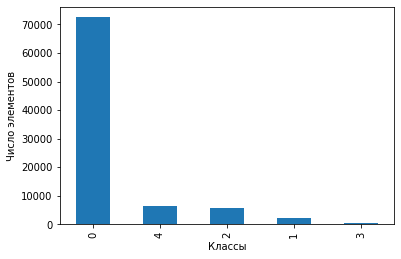

In [57]:
count_columns = len(test_data.iloc[0])
last_column_id = count_columns - 1

train_data[last_column_id] = train_data[last_column_id].astype(int)
test_data[last_column_id] = test_data[last_column_id].astype(int)

statistic = train_data[last_column_id].value_counts().plot(kind='bar', xlabel="Классы", ylabel="Число элементов")


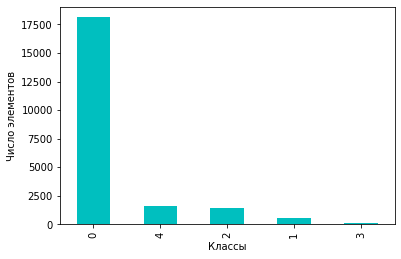

In [58]:
statistic = test_data[last_column_id].value_counts().plot(kind='bar', color="c", xlabel="Классы", ylabel="Число элементов")

In [59]:
train_values = train_data.values
test_values = test_data.values

In [60]:
X_train = train_values[:, :-1]
y_train = train_values[:, -1].astype(int)

X_test = test_values[:, :-1]
y_test = test_values[:, -1].astype(int)

In [61]:
class0, class1, class2, class3, class4 = get_classes_flatten(y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

# For working of SVM and K-Neighbor Classifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_jobs=-1)
grid = GridSearchCV(clf, {'n_neighbors': range(1, 100)}, cv=5, verbose=1, n_jobs = -1)
knn = grid.fit(X_train, y_train)

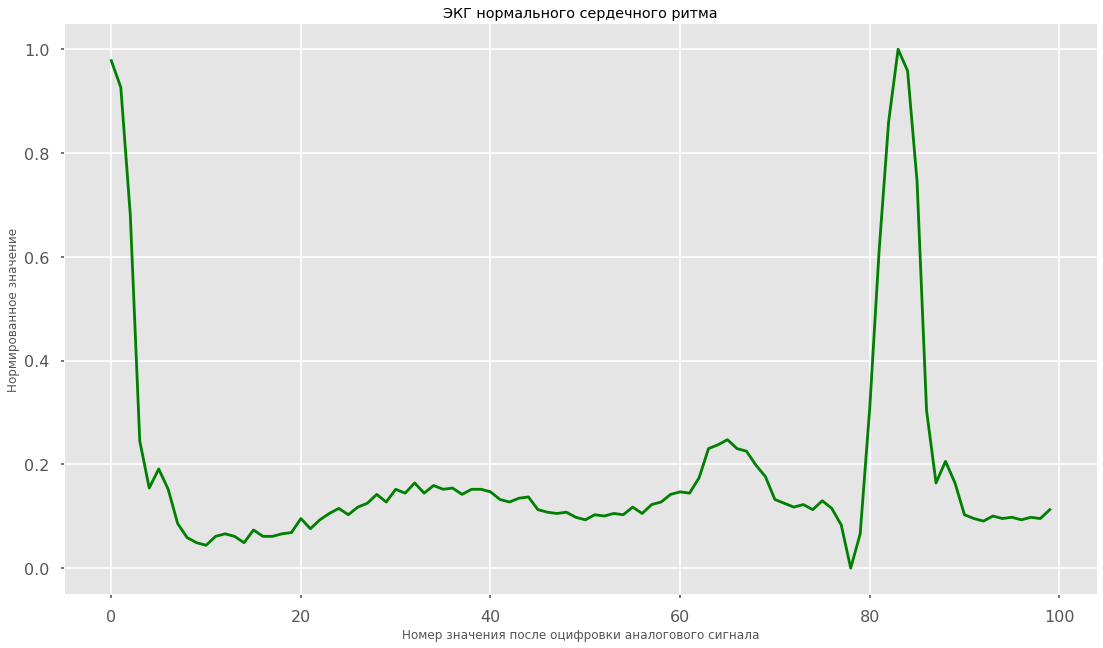

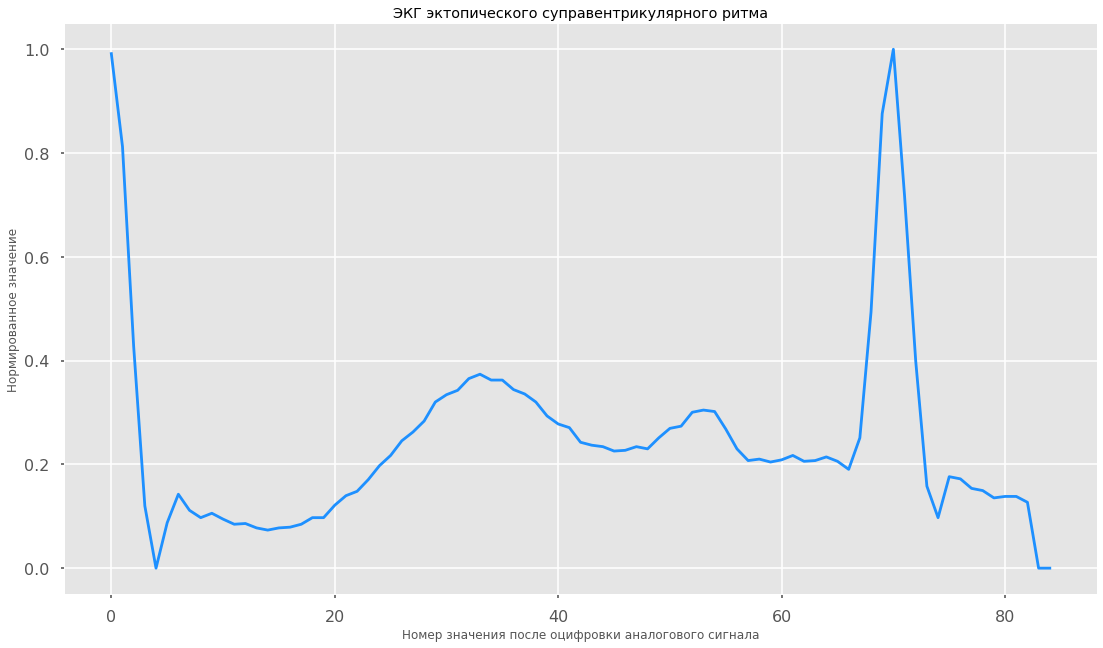

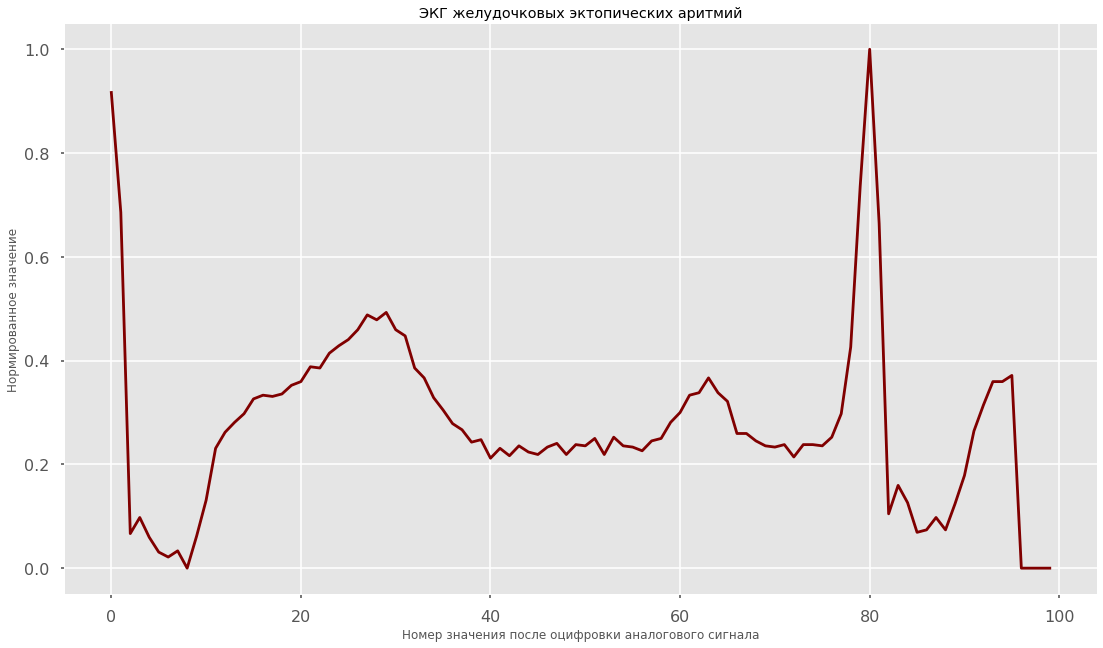

In [48]:
import matplotlib.style as style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class0][0][:100], color="g")

plt.title('ЭКГ нормального сердечного ритма')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class1][0][:85], color="dodgerblue")

plt.title('ЭКГ эктопического суправентрикулярного ритма')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class2][2][:100], color="maroon")

plt.title('ЭКГ желудочковых эктопических аритмий')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.show()



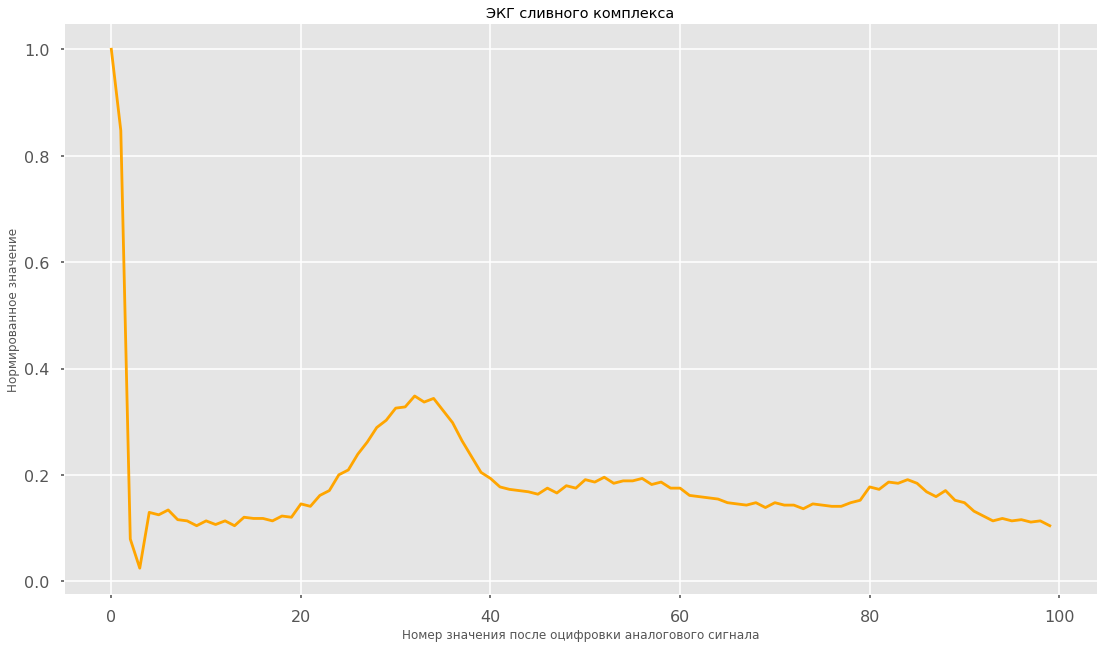

In [57]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class3][5][:100], color="orange")

plt.title('ЭКГ сливного комплекса')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.show()

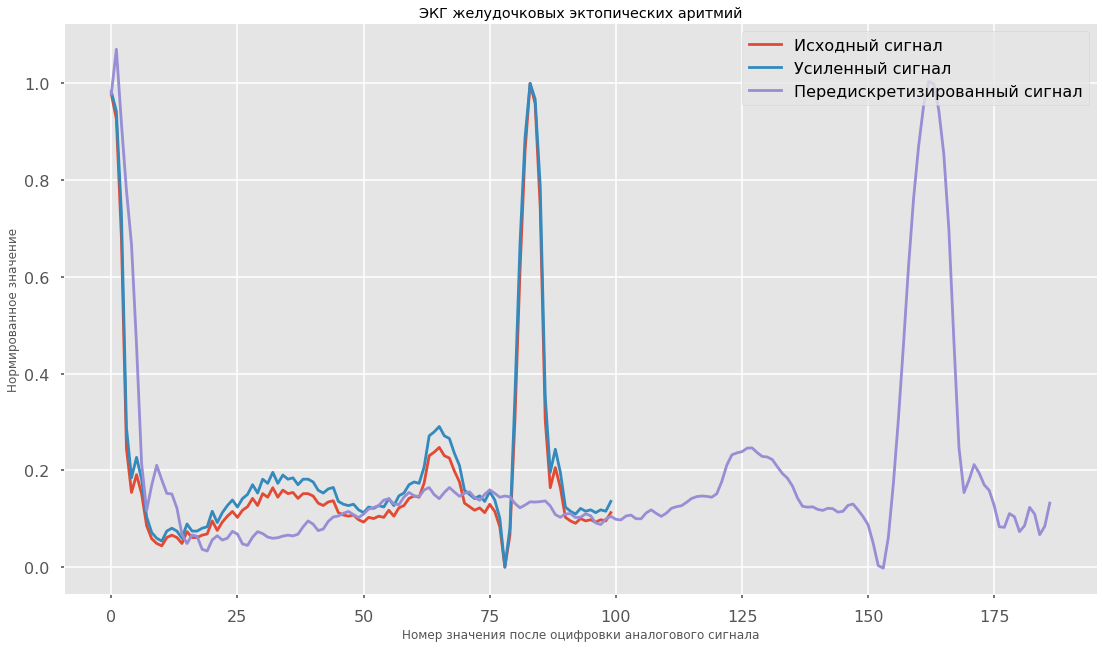

In [85]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class0][0][:100])
plt.plot(get_amplify(X_train[class0][0][:100]))
plt.plot(get_stretch(X_train[class0][0][:100]))

plt.title('ЭКГ желудочковых эктопических аритмий')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.legend(['Исходный сигнал', 'Усиленный сигнал', 'Передискретизированный сигнал'], loc='upper right')
plt.show()

In [62]:
data1 = np.apply_along_axis(get_augment, axis=1, arr=X_train[class1]).reshape(-1, count_columns - 1)
data1_classes = np.ones(shape=(data1.shape[0],), dtype=int)*1

data3 = np.apply_along_axis(get_augment, axis=1, arr=X_train[class3]).reshape(-1, count_columns - 1)
data3_classes = np.ones(shape=(data3.shape[0],), dtype=int)*3

X_train_aug = np.vstack([X_train, data1, data3])
y_train_aug = np.hstack([y_train, data1_classes, data3_classes])

In [63]:
count_columns = 188 # previous ipynb (187 + label)
random_size = 150 # random

one_hot_encoder = OneHotEncoder()

In [64]:
X_train = np.expand_dims(X_train, 2)
X_train_aug = np.expand_dims(X_train_aug, 2)
X_test = np.expand_dims(X_test, 2)

y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_train_aug = one_hot_encoder.fit_transform(y_train_aug.reshape(-1, 1))
y_test = one_hot_encoder.transform(y_test.reshape(-1, 1))

In [65]:
def plot_confusion_matrix(confusion_matrix, classes, normalize=False):    
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    threshold = confusion_matrix.max() / 2.
    
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [66]:
# Build model

In [67]:
def my_exp(epoch):
    init_learning_rate = 0.001
    k = 0.40
    t = X_train_aug[0] // (10000 * 500) 
    learning_rate = init_learning_rate * math.exp(-k * t)
    return learning_rate

learning_rate = LearningRateScheduler(my_exp)
adam_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [68]:
input_shape = X_train.shape
strides_small, strides_big, k_size = 1, 2, 3

In [131]:
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers import BatchNormalization

def build_keras_model():   
    
    K.clear_session()

    input0 = Input(shape=input_shape[1:])
    cntn = Conv1D(filters=64, kernel_size=k_size, strides=strides_small) (input0)

    cntn1_it1 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(cntn)
    actn1_it1 = Activation("relu")(cntn1_it1)
    
    cntn2_it1 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it1)
    adg_1 = Concatenate(axis=1)([cntn2_it1, cntn])
    actn2_it1 = Activation("relu")(adg_1)
    
    max_pooling_1 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it1)
    drop_it1 = Dropout(.1)(max_pooling_1)

    cntn1_it2 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(drop_it1)
    actn1_it2 = Activation("relu")(cntn1_it2)
    
    cntn2_it2 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it2)
    adg_2 = Concatenate(axis=1)([cntn2_it2, max_pooling_1])
    actn2_it2 = Activation("relu")(adg_1)
    
    max_pooling_2 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it2)
    drop_it2 = Dropout(.1)(max_pooling_2)

    cntn1_it3 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(drop_it2)
    actn1_it3 = Activation("relu")(cntn1_it3)
    
    cntn2_it3 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it3)
    adg_3 = Concatenate(axis=1)([cntn2_it3, max_pooling_2])
    actn2_it3 = Activation("relu")(adg_3)
    
    max_pooling_3 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it3)
    drop_it3 = Dropout(.1)(max_pooling_3)


    cntn1_it4 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(drop_it3)
    actn1_it4 = Activation("relu")(cntn1_it4)
    
    cntn2_it4 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it4)
    adg_4 = Concatenate(axis=1)([cntn2_it4, max_pooling_3])
    actn2_it4 = Activation("relu")(adg_4)
    
    max_pooling_4 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it4)
    drop_it4 = Dropout(.1)(max_pooling_4)

    cntn1_it5 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(drop_it4)
    actn1_it5 = Activation("relu")(cntn1_it5)
    
    cntn2_it5 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it5)
    adg_5 = Concatenate(axis=1)([cntn2_it5, max_pooling_4])
    actn2_it5 = Activation("relu")(adg_5)
    
    max_pooling_5 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it5)
    drop_it5 = Dropout(.1)(max_pooling_5)

    result_flatten = Flatten()(drop_it5)

    dense = Dense(64)(result_flatten)
    actn_result = Activation("relu")(dense)
    dense_prefinal = Dense(64)(actn_result)
    dense_final = Dense(5)(dense_prefinal)
    output0 = Softmax()(dense_final)

    model = Model(inputs=input0, outputs=output0)

    return model

In [132]:
model = build_keras_model()

In [133]:
# Run
model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [134]:
history = model.fit(X_train_aug,
                    y_train_aug,
                    epochs=100,
                    batch_size=2000,
                    verbose=2,
                    validation_data=(X_test, y_test), callbacks=[learning_rate])
                   

Train on 99010 samples, validate on 21892 samples
Epoch 1/100
 - 8s - loss: 0.7232 - accuracy: 0.7827 - val_loss: 0.2884 - val_accuracy: 0.9203
Epoch 2/100
 - 7s - loss: 0.3085 - accuracy: 0.9062 - val_loss: 0.1353 - val_accuracy: 0.9623
Epoch 3/100
 - 7s - loss: 0.2030 - accuracy: 0.9360 - val_loss: 0.1128 - val_accuracy: 0.9670
Epoch 4/100
 - 7s - loss: 0.1684 - accuracy: 0.9463 - val_loss: 0.1002 - val_accuracy: 0.9717
Epoch 5/100
 - 7s - loss: 0.1403 - accuracy: 0.9531 - val_loss: 0.0851 - val_accuracy: 0.9756
Epoch 6/100
 - 7s - loss: 0.1235 - accuracy: 0.9588 - val_loss: 0.0758 - val_accuracy: 0.9783
Epoch 7/100
 - 7s - loss: 0.1073 - accuracy: 0.9634 - val_loss: 0.0724 - val_accuracy: 0.9793
Epoch 8/100
 - 7s - loss: 0.0976 - accuracy: 0.9667 - val_loss: 0.0678 - val_accuracy: 0.9809
Epoch 9/100
 - 7s - loss: 0.0868 - accuracy: 0.9703 - val_loss: 0.0643 - val_accuracy: 0.9824
Epoch 10/100
 - 7s - loss: 0.0809 - accuracy: 0.9716 - val_loss: 0.0589 - val_accuracy: 0.9841
Epoch 11/

In [137]:
import time
start_time = time.time()
model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.4572803974151611 seconds ---


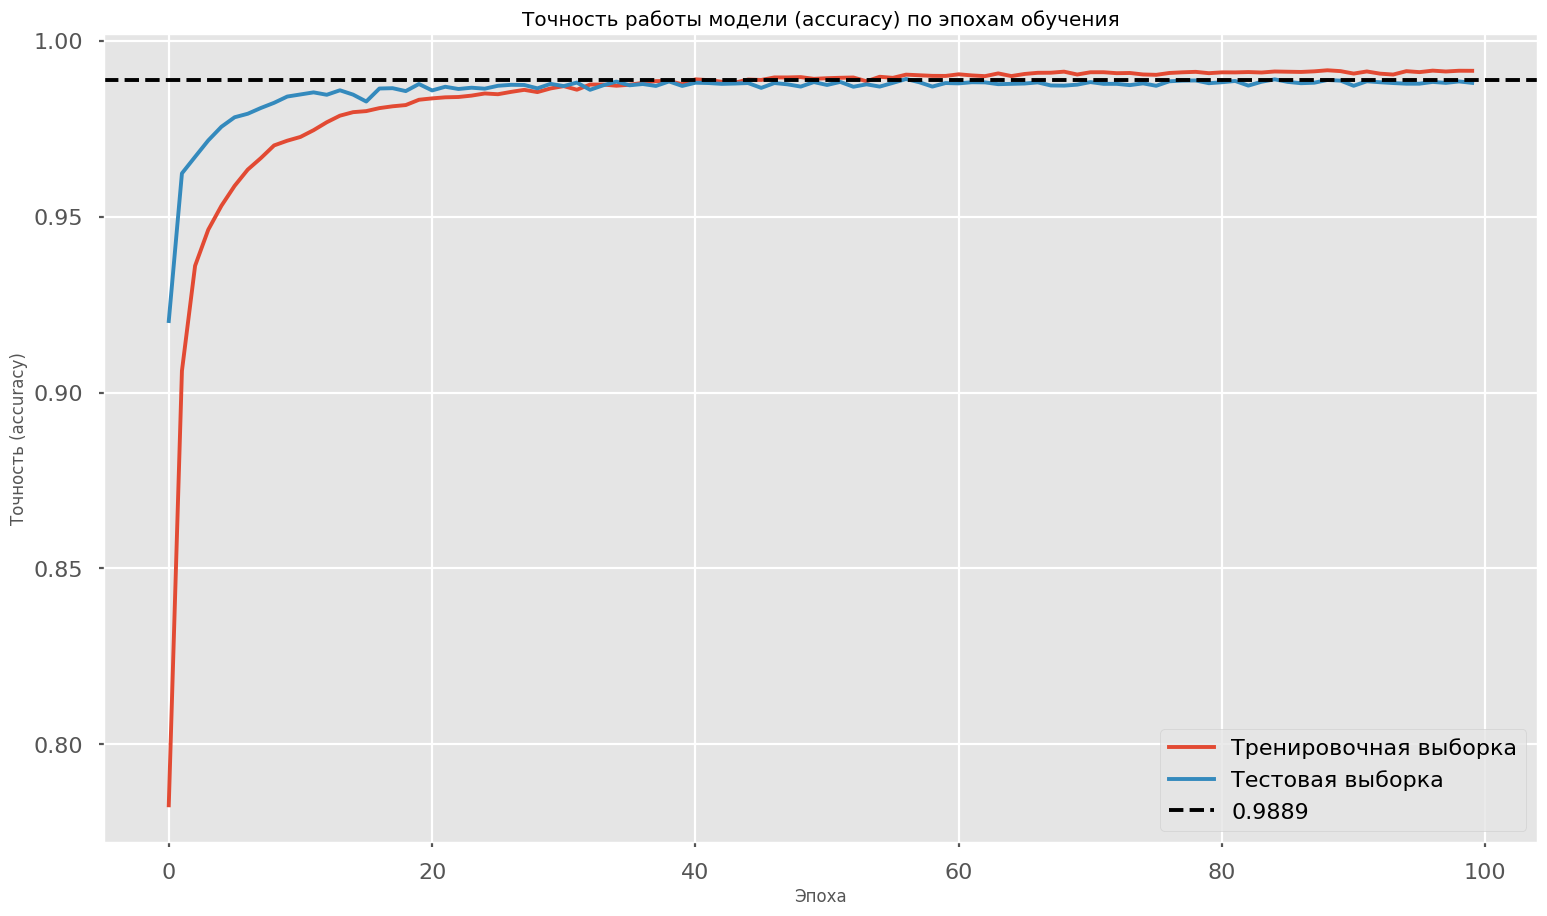

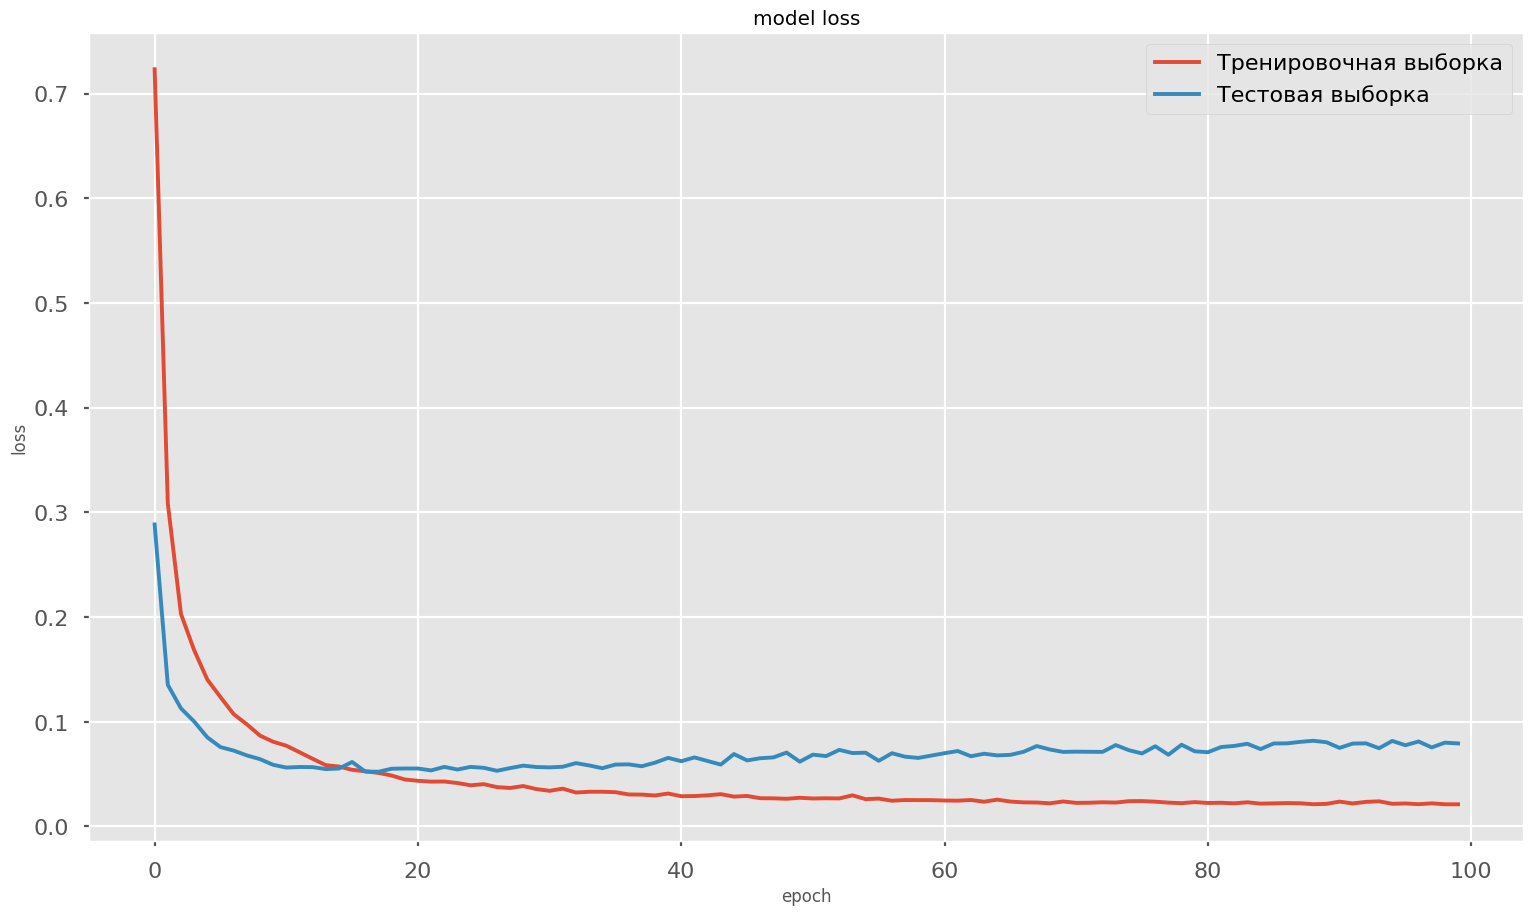

In [135]:
import matplotlib.style as style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=0.9889, color="black", linestyle="--", label="")

plt.title('Точность работы модели (accuracy) по эпохам обучения')
plt.ylabel('Точность (accuracy)')
plt.xlabel('Эпоха')
plt.legend(['Тренировочная выборка', 'Тестовая выборка', "0.9889"], loc='lower right')
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Тренировочная выборка', 'Тестовая выборка'], loc='upper right')

plt.show()

In [100]:
y_pred = model.predict(X_test, batch_size=2000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print("Ranking-based prec avg: {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.89      0.84      0.87       556
           2       0.97      0.96      0.96      1448
           3       0.78      0.88      0.82       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.93      0.93      0.93     21892
weighted avg       0.99      0.99      0.99     21892

Ranking-based prec avg: 0.993


Normalized confusion matrix


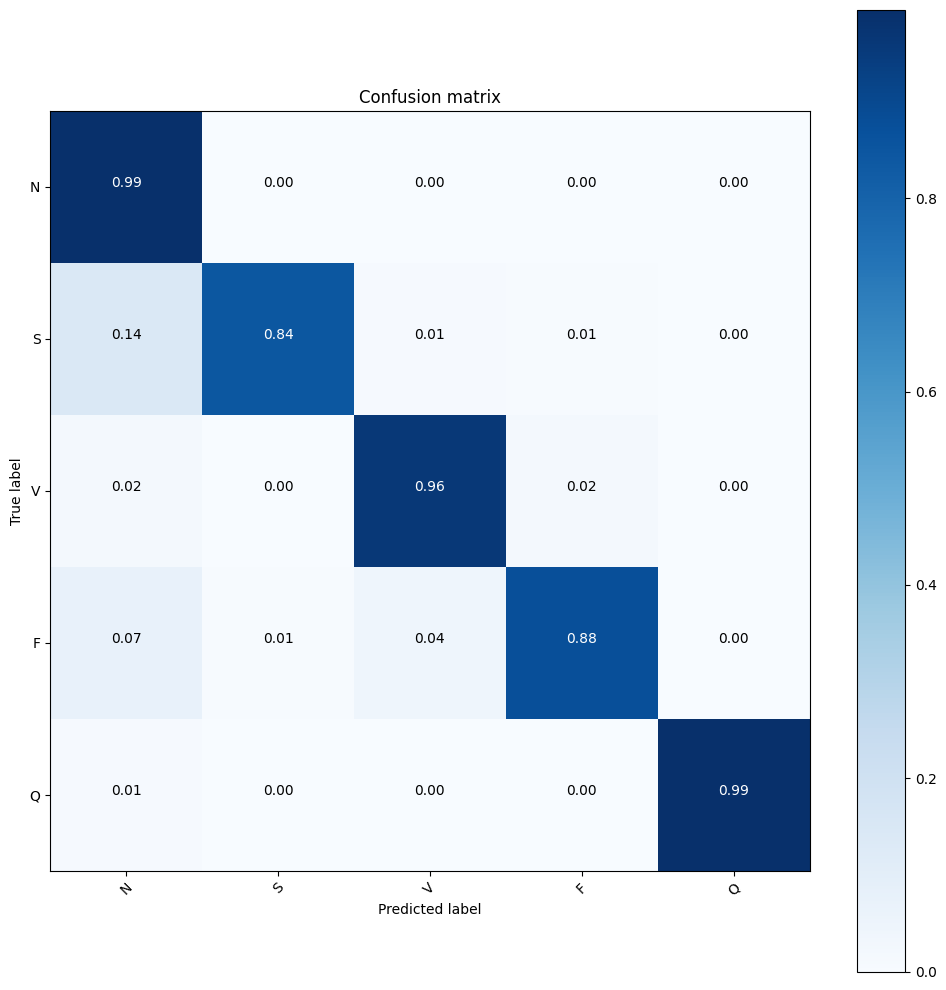

In [101]:
plt.rcParams.update(plt.rcParamsDefault)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

np.set_printoptions(precision=2)
plt.figure(figsize=(10, 10))

plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'], normalize=True)
plt.show()